In [6]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy
import import_ipynb
import GP_util #load module first
import importlib
importlib.reload(GP_util) # reload full module
from GP_util import unique, select, distancematrix,linear_pixel
#import methods from reloaded module

importing Jupyter notebook from GP_util.ipynb


In [7]:
datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_24.csv'
df = pd.read_csv(datapath)

df = select(df, n=200) # selects subset of df for time/memory reductions

In [8]:
f, df_unique, zero_farm_idx, Num_farms = unique(df)

there are 195 unique farms in loaded df


In [195]:
#def distancematrix(df, distance_calc=True, sparse=False, dlim=100):
"""
inputs: df

returns:
    1.) distance between all farms in miles
    2.) distance^2

"""
from scipy.spatial import distance_matrix
from geopy.distance import geodesic
unique_farms = pd.unique(df.pixel)
distance = np.zeros((unique_farms.size,unique_farms.size))
df_unique = df.set_index('pixel')
df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index values

for i in range(unique_farms.size):
    lat_lon_i = df_unique.Latitude.iloc[i],df_unique.Longitude.iloc[i]
    for j in range(i):
        lat_lon_j = df_unique.Latitude.iloc[j],df_unique.Longitude.iloc[j]
        if distance_calc == True:
            distance[i,j] = geodesic(lat_lon_i, lat_lon_j).miles
            distance[j,i] = distance[i,j] # make use of symmetry
#    return distance, np.power(distance, 2)



In [166]:
#distance, Dmatsq = distancematrix(df, distance_calc=True, sparse=False, dlim=75)
#d,dmatsq = distancematrix(df)

In [121]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    l = pm.Gamma('l', alpha = 3, beta=.01)
    #l = pm.HalfCauchy('l', 100)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-2
    Kij = etasq*(np.exp(-Dmatsq/l**2)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, l, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [02:03<00:00, 13.49draws/s]
The acceptance probability does not match the target. It is 0.8871660405551649, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


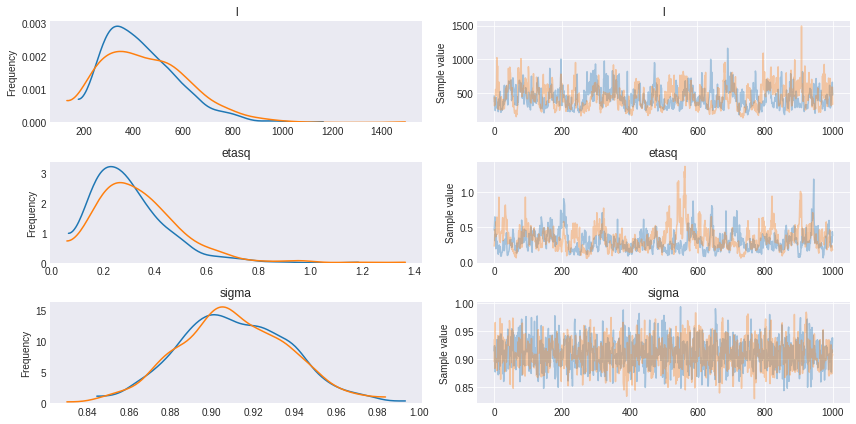

In [122]:
pm.traceplot(trace, varnames=['l','etasq','sigma']);

In [123]:
pm.summary(trace,varnames=['sigma','l','etasq'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.910476,0.026518,0.000675,0.859054,0.962108,1380.475480,0.999748
l,442.165260,159.919174,8.816269,195.580768,768.918756,241.787315,1.002147
etasq,0.321950,0.156430,0.010264,0.084576,0.625927,111.229443,1.019504


In [232]:
with pm.Model() as GP_uncentered:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    #lsq = pm.Gamma('lsq', alpha = 3.5, beta=1.2e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    ls = pm.Gamma('ls',alpha=3, beta=.01)
    #ls = pm.HalfCauchy('ls', 200)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    
    sigmay = 1e-2
    Kij = etasq*(np.exp(-Dmatsq/ls**2)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
    
    # ========== gaussian process informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    # to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z))
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    #trace_uc = pm.sample(1000,tune=100,chains=2,nuts_kwargs={'target_accept': .95})
    trace_n = pm.sample(1000,chains=2)

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, z, ls, etasq]
Sampling 2 chains: 100%|██████████| 3000/3000 [1:49:27<00:00,  1.64s/draws]
The number of effective samples is smaller than 25% for some parameters.


In [1]:
pm.summary(trace_n,varnames=['sigma','ls','etasq'])

NameError: name 'pm' is not defined

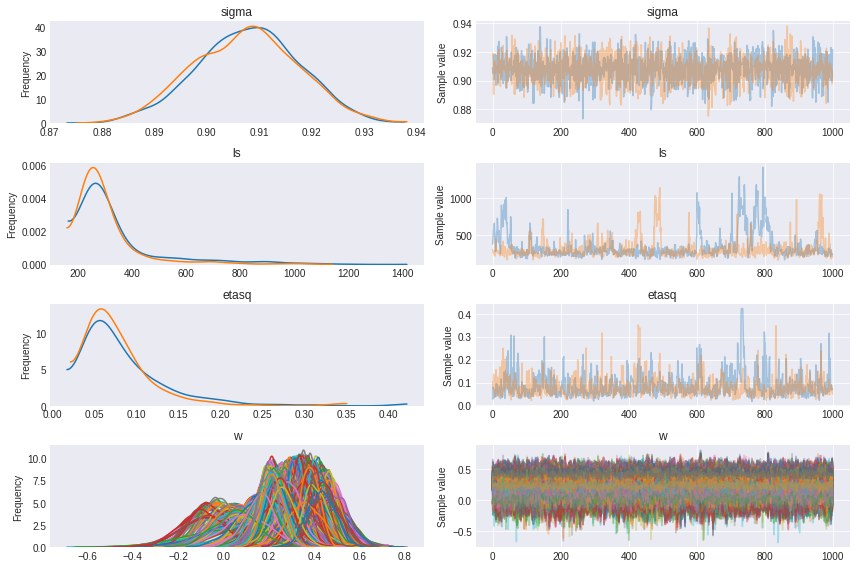

In [214]:
pm.traceplot(trace_n,varnames=['sigma','ls','etasq','w']);

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 's'
  s)


NameError: name 'w_75' is not defined

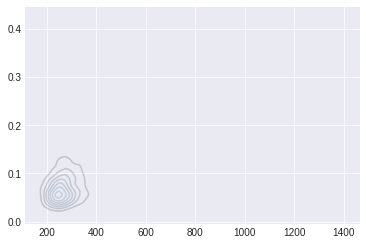

In [213]:
sns.kdeplot(trace_n['ls'], trace_n['etasq'], s=2, alpha=.2);
trace_n[w_75]

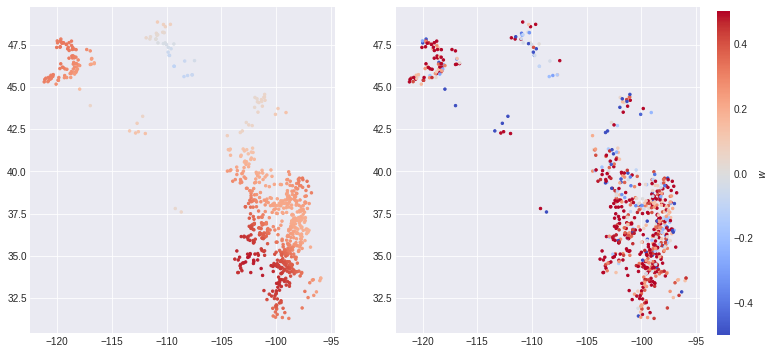

In [199]:
v = .5
fig, ax = plt.subplots(1,2, figsize=(12,6))
im = ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_n['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=df_unique.B_zprsum3,
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label='$w$');

No handles with labels found to put in legend.


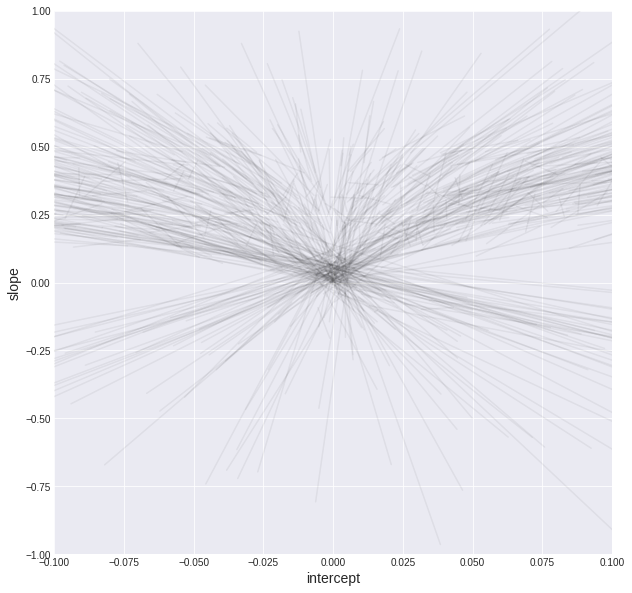

In [231]:
b1 = trace_n['w'].mean(axis=0)
a1 = trace_n['a'].mean(axis=0)

a2 = df_unique['a_zprsum3']
b2 = df_unique['B_zprsum3']

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.scatter(a0,b0,label='Ordinary Least Squares', s=10)
#ax.scatter(a2, b2, label='OLS', c='k',s=5, alpha=.4)
#ax.scatter(a1, b1, label='Gaussian Process', s=5, alpha=1)



#ax.plot([a1, a0], [b1, b0], 'k-', alpha=.05)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.05)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
#ax.set_title('studentT = .3 vs. studentT sigma=RV')
ax.set_xlim(-.1,.1)
ax.set_ylim(-1,1)
ax.legend();

In [215]:
df_unique['B_zprsum3'] = 0
df_unique['a_zprsum3'] = 0
column_x='zprsum3'
for i,p in enumerate(df_unique.index):
    mu,C = linear_pixel(df, p, column_x=column_x,column_y='zNDVIsum3', c=None,cluster=False)
    df_unique.loc[(df_unique.index == p),'B_' + column_x] = mu[1]
    df_unique.loc[(df_unique.index == p),'a_' + column_x] = mu[0]

In [144]:
import scipy
Kij_sparse = scipy.sparse.csr_matrix(Kij)

In [145]:
Kij_sparse

<98x98 sparse matrix of type '<class 'numpy.float64'>'
	with 9604 stored elements in Compressed Sparse Row format>

In [147]:
pm.sample?
